In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'

2023-02-07 13:58:59.257012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 13:58:59.427662: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-07 13:59:00.289305: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2023-02-07 13:59:00.289441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

# Create training data set

In [2]:
def create_training_data(dir_path):
    
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v11.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v11.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v11.root")
    
    sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
    bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
    qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()
    
    reco_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[:400000]
    deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:400000]
    eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:400000]
    selection_sig = (reco_pt_sig > 20.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
    
    reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:400000]
    selection_bkg = reco_pt_bkg > 20.
    
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > 20.
    
    #Maybe better to use 2.4 for eta
    
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)
    
    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
    
    X_train = np.concatenate([X_sig, X_bkg, X_qcd])
    y_train = np.concatenate([y_sig, y_bkg, y_qcd])
    
    X_train[abs(X_train) > 1e+4] = 0.
    
    assert not np.any(np.isnan(X_train))
    assert not np.any(np.isnan(y_train))
    
    return X_train, y_train

In [3]:
X_train, y_train = create_training_data("../ntuples/Jan_25_2023")

## Model

In [4]:
model = Sequential()
model.add(Dense(25, activation = 'relu', input_shape=X_train.shape[1:]))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                2025      
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,406
Trainable params: 2,406
Non-trainable params: 0
_________________________________________________________________


2023-02-03 22:31:35.488781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 22:31:36.627270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 500 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:65:00.0, compute capability: 8.0
2023-02-03 22:31:36.628863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21314 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [5]:
#Train the network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)
 
model.fit(X_train, y_train,
          epochs=50,
          batch_size=50,
          verbose=2,
          validation_split=0.20,
          callbacks=[callback])

Epoch 1/50


2023-02-03 22:31:39.472606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4677/4677 - 9s - loss: 0.3011 - binary_accuracy: 0.8684 - val_loss: 0.1417 - val_binary_accuracy: 0.9312 - 9s/epoch - 2ms/step
Epoch 2/50
4677/4677 - 8s - loss: 0.2747 - binary_accuracy: 0.8768 - val_loss: 0.1654 - val_binary_accuracy: 0.9220 - 8s/epoch - 2ms/step
Epoch 3/50
4677/4677 - 8s - loss: 0.2671 - binary_accuracy: 0.8807 - val_loss: 0.1664 - val_binary_accuracy: 0.9269 - 8s/epoch - 2ms/step
Epoch 4/50
4677/4677 - 8s - loss: 0.2613 - binary_accuracy: 0.8853 - val_loss: 0.1509 - val_binary_accuracy: 0.9320 - 8s/epoch - 2ms/step
Epoch 5/50
4677/4677 - 8s - loss: 0.2590 - binary_accuracy: 0.8863 - val_loss: 0.1362 - val_binary_accuracy: 0.9359 - 8s/epoch - 2ms/step
Epoch 6/50
4677/4677 - 7s - loss: 0.2573 - binary_accuracy: 0.8874 - val_loss: 0.1519 - val_binary_accuracy: 0.9333 - 7s/epoch - 2ms/step
Epoch 7/50
4677/4677 - 7s - loss: 0.2561 - binary_accuracy: 0.8879 - val_loss: 0.1326 - val_binary_accuracy: 0.9389 - 7s/epoch - 2ms/step
Epoch 8/50
4677/4677 - 7s - loss: 0.2548 - bi

In [6]:
#Save the model
model.save(model_name)

## Efficiency on training set

In [7]:
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
truth_tau_pt = sig['ntuplePupSingle']['tree']['genpt1'].array()[:400000]
reco_tau_pt = sig['ntuplePupSingle']['tree']['pt'].array()[:400000]

#Load model and select out the tau
model = load_model(model_name)

#Get all the inputs
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]

pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[:400000]
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:400000]
eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:400000]

selection_sig = (pt_sig > 20) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)

#Selected out the tau pt with the basic cuts first
truth_tau_pt_select = truth_tau_pt[selection_sig]
reco_tau_pt_select = reco_tau_pt[selection_sig]

In [8]:
X_sig = np.asarray(sig_input[selection_sig])
y_sig_model = model.predict(np.nan_to_num(X_sig))

2771/2771 [==============================] - 2s 715us/step


In [9]:
#y_sig = score_transform(np.asarray(y_sig_model).flatten(), np.asarray(reco_tau_pt_select).flatten())

In [10]:
nn_cut = y_sig_model.flatten() > 0.05

In [11]:
tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[:400000][selection_sig])
tau_pt_old_nn = truth_tau_pt_select[old_tau_select == 1]

#Fill two plots and divide the two.
pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
pT_axis = hist.axis.Variable(pT_egdes, name = r"$\tau_h$ $p_T$")

hist_all_tau = Hist(pT_axis)
hist_selected_tau = Hist(pT_axis)
hist_selected_old_tau = Hist(pT_axis)

hist_all_tau.fill(truth_tau_pt_select)
hist_selected_tau.fill(tau_pt_nn)
hist_selected_old_tau.fill(tau_pt_old_nn)

Hist(Variable([0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 100, 125, 150], name='$\\tau_h$ $p_T$'), storage=Double()) # Sum: 79429.0 (81816.0 with flow)

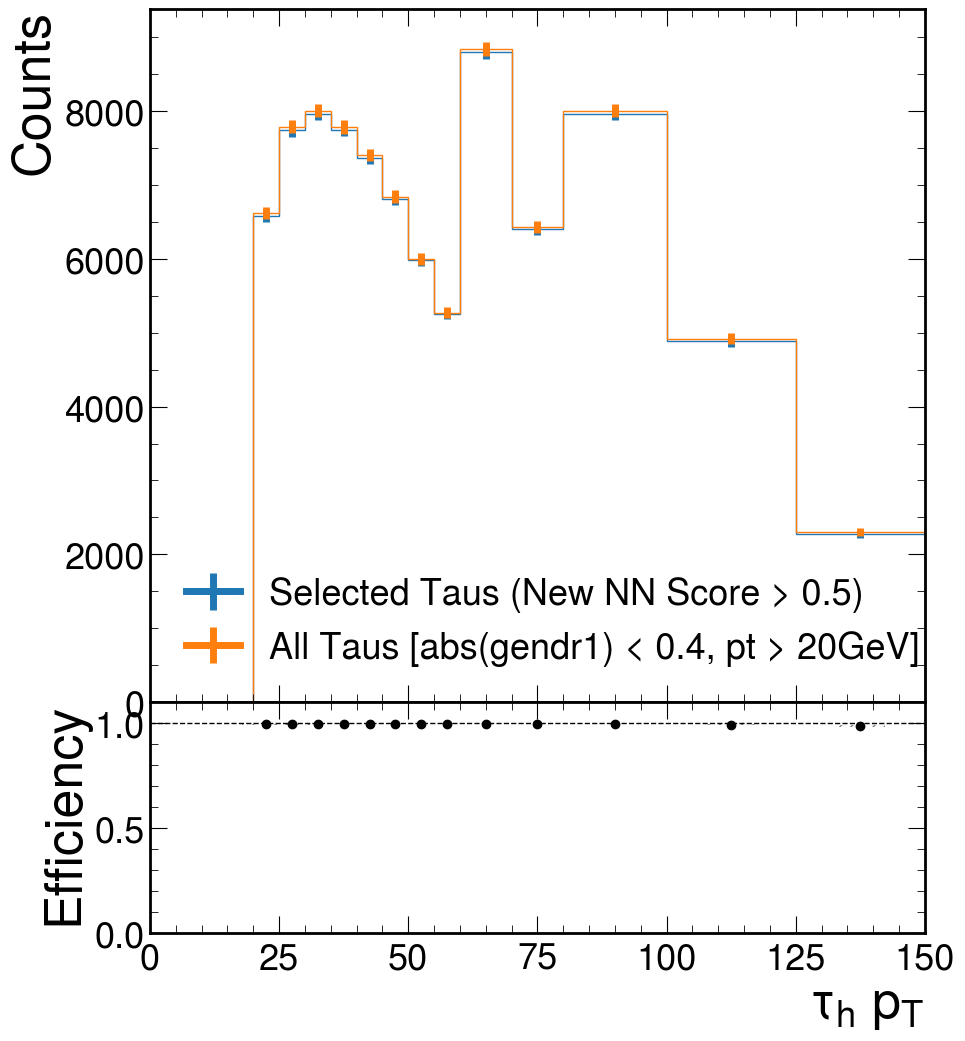

In [12]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (New NN Score > 0.5)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

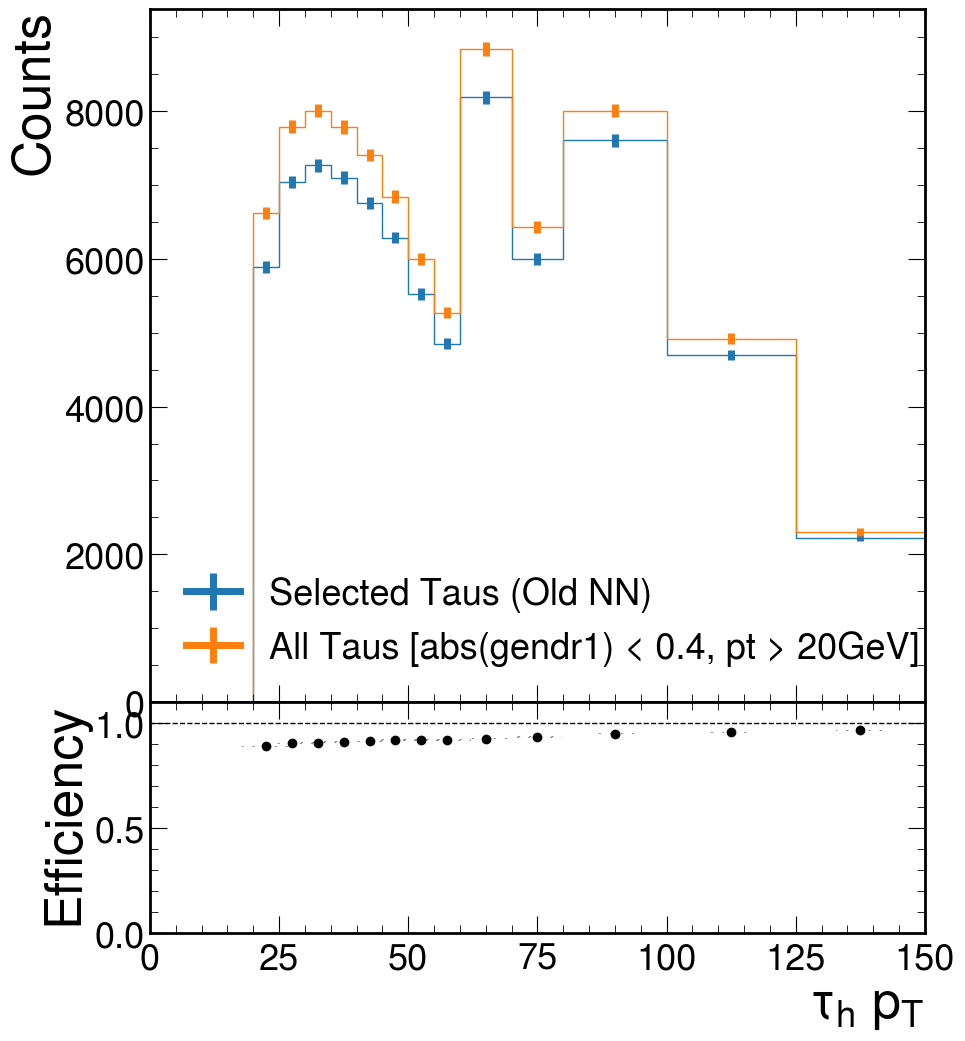

In [13]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (Old NN)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

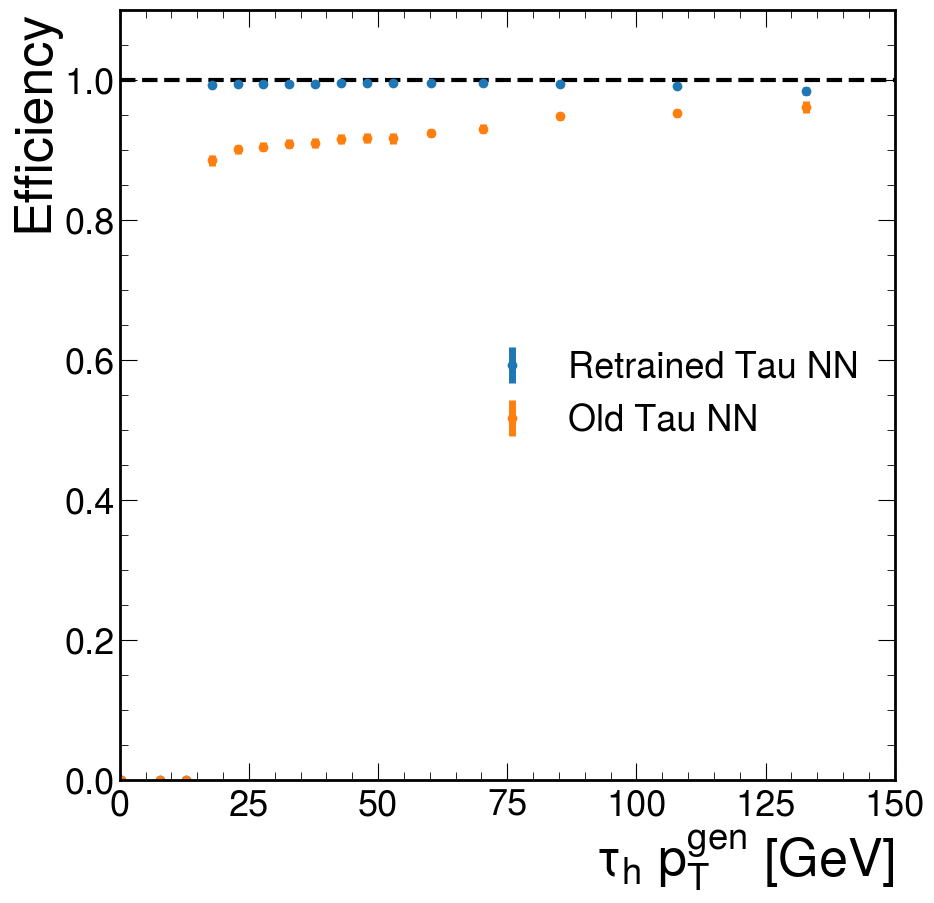

In [14]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN')

plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([0,150])
plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
plt.ylabel("Efficiency")
plt.legend(loc = 'center right')
plt.show()

# Check out the loss profile

In [2]:
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
truth_tau_pt = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[400000:])
reco_tau_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[400000:])

#Load model and select out the tau
model = load_model(model_name)

#Get all the inputs
sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[400000:])

pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[400000:])
deltaR_sig = np.asarray(sig['ntuplePupSingle']['tree']['gendr1'].array()[400000:])
eta_sig = np.asarray(sig['ntuplePupSingle']['tree']['geneta1'].array()[400000:])

selection_sig = (pt_sig > 20) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)

#Selected out the tau pt with the basic cuts first
truth_tau_pt_select = truth_tau_pt[selection_sig]
reco_tau_pt_select = reco_tau_pt[selection_sig]

2023-02-04 12:39:48.156080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 12:39:49.355825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 500 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:65:00.0, compute capability: 8.0
2023-02-04 12:39:49.357795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21719 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [3]:
X_sig = np.asarray(sig_input[selection_sig])
X_sig[abs(X_sig) > 1e+4] = 0.
y_sig = model.predict(np.nan_to_num(X_sig))

 157/1405 [==>...........................] - ETA: 1s

2023-02-04 12:39:51.670981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1405/1405 [==============================] - 2s 928us/step


In [4]:
pT_egdes = [20,25,30,35,40,45,50,55,60,70,80,100,125,150,200]
mean_pt = []

mean_score_80_NoT = []
mean_score_90_NoT = []
mean_score_95_NoT = []

for i in range(len(pT_egdes) - 1):
    print("pt range: {} to {}".format(pT_egdes[i],pT_egdes[i+1]))
    mean_pt.append((pT_egdes[i] + pT_egdes[i+1])/2)
    
    y_sig_select = y_sig[(truth_tau_pt_select > pT_egdes[i]) & (truth_tau_pt_select < pT_egdes[i+1])]
    
    mean_score_80_NoT.append(np.percentile(y_sig_select,20))
    mean_score_90_NoT.append(np.percentile(y_sig_select,10))
    mean_score_95_NoT.append(np.percentile(y_sig_select,5))

pt range: 20 to 25
pt range: 25 to 30
pt range: 30 to 35
pt range: 35 to 40
pt range: 40 to 45
pt range: 45 to 50
pt range: 50 to 55
pt range: 55 to 60
pt range: 60 to 70
pt range: 70 to 80
pt range: 80 to 100
pt range: 100 to 125
pt range: 125 to 150
pt range: 150 to 200


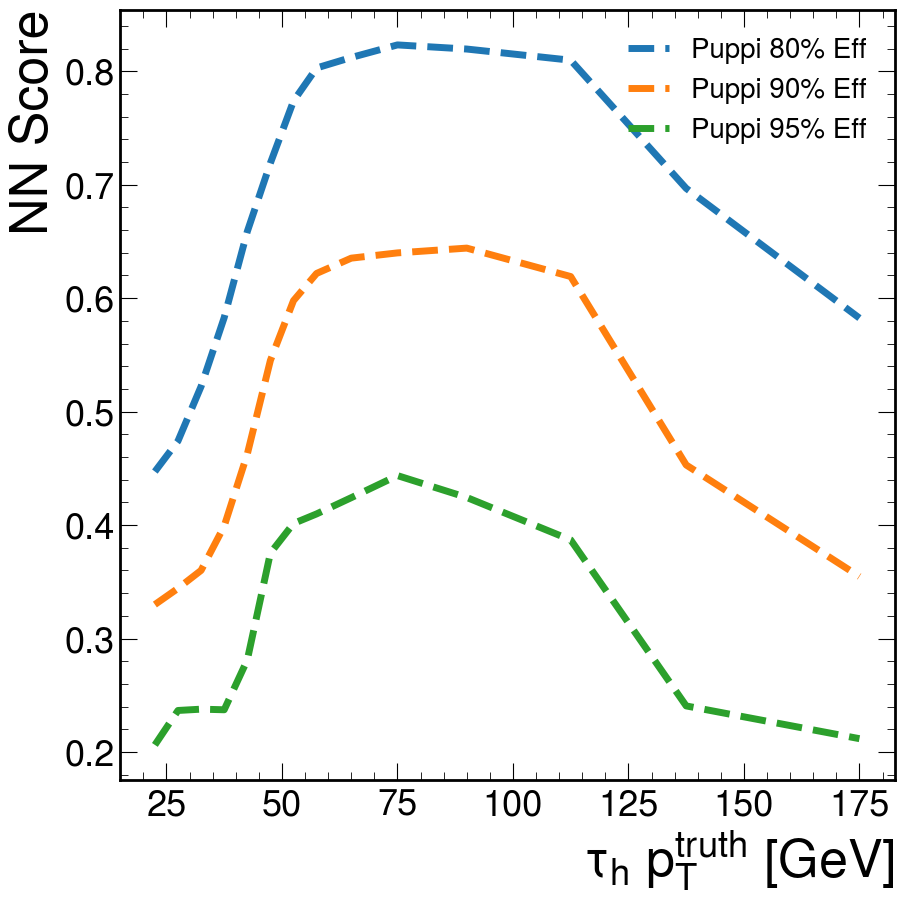

In [5]:
plt.plot(mean_pt[:15], mean_score_80_NoT[:15], linestyle = '--', label='Puppi 80% Eff')
plt.plot(mean_pt[:15], mean_score_90_NoT[:15], linestyle = '--', label='Puppi 90% Eff')
plt.plot(mean_pt[:15], mean_score_95_NoT[:15], linestyle = '--', label='Puppi 95% Eff')

plt.xlabel(r"$\tau_h$ $p_T^{truth}$ [GeV]")
plt.ylabel("NN Score")
#plt.ylim([0,0.8])
plt.legend(fontsize=20)
plt.show()